In [1]:
using JuLIP, JuLIP.ASE, JuLIP.Potentials 
using PyPlot

function plot2d(at, ttl = nothing)
    x, y, _ = xyz(at)
    plot(x, y, "b.", markersize=20)
    if ttl != nothing
        title(ttl)
    end 
    PyPlot.draw()
    PyPlot.pause(0.0001)    
end 

# NOTES 
#
# 1. For now, this notebook is just to implement a temporary
#    example for MD, Newtonian dynamics. This functionality
#    should be moved into the JuLIP library, using more
#    sophisticated integrators. 
#
# 2. PyPlot is horrendously slow, should maybe switch to GR
#    or Plotly for generating the animation

plot2d (generic function with 2 methods)

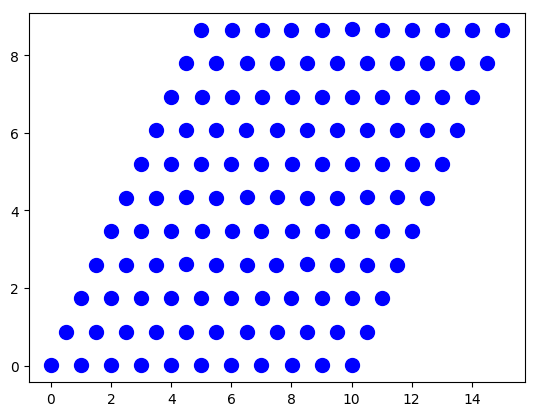

In [2]:
# problem parameters 
r0 = 1.0  # atomic spacing 
N = 11    # number of atoms in each direction 

# generate positions  (for real crystals this is automated)
t = linspace(0.0, (N-1)*r0, N)
o = ones(N)
x, y = t * o', o * t'
X = [ [1.0 0.5; 0.0 √3/2] * [x[:]'; y[:]']; zeros(N^2)' ]
X = (X + 0.01*rand(size(X))) |> vecs
# generate the atoms object  (H is just a place-holder)
at = Atoms("H$(length(X))", X) 
set_cell!(at, diagm([2.0*N, 2.0*N, 1.0]))
set_pbc!(at, (true, true, true))
set_constraint!(at, FixedCell(at))
plot2d(at)

In [3]:
# # generate a pair potential 
# lj = lennardjones() 
# set_calculator!(at, lj)

# or could do it by hand: 
lj = (@analytic r -> r^(-12) - 2 * r^(-6)) * SplineCutoff(1.7, 2.5)
set_calculator!(at, lj)
;

In [4]:
# this should be done properly, using in particular 
# a proper scaling of the gaussian depending on temperature 
q = position_dofs(at) 
p = randn(length(q)) * 0.1
set_momentum_dofs!(at, p) 
write("md.xyz", at)
# prepare for plotting
pygui(true)
PyPlot.ion()
# create a counter to save only every 10 steps 
cnt = 0 
dt = 0.003
E0 = energy(at, q)
Ep = [energy(at, q)-E0]
Ek = [0.5 * norm(p)^2] 
for n = 1:1_000
    p -= dt * gradient(at, q)    # Euler-A method
    q += dt * p
    cnt += 1
    push!(Ep, energy(at, q) - E0)
    push!(Ek, 0.5 * vecnorm(p)^2)
    if cnt == 40 
        cnt = 0 
        # write current configuration into at
        set_position_dofs!(at, q) 
        set_momentum_dofs!(at, p)
        # write to file
        write("md.xyz", at, :append)
        PyPlot.cla()
        plot2d(at, "n = $(n), Ep = $(Ep[end]), Ek = $(Ek[end])") 
    end 
end 


/Users/ortner/.local/lib/python2.7/site-packages/matplotlib/backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


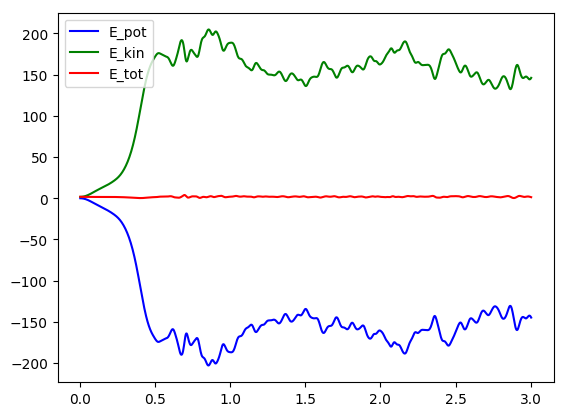

PyObject <matplotlib.legend.Legend object at 0x145e6ae10>

In [5]:
PyPlot.pygui(false)
x = collect(1:length(Ep)) * dt
plot(x, Ep, "b-", x, Ek, "g-", x, Ep+Ek, "r-")
legend(("E_pot", "E_kin", "E_tot"))